# Revenue Forecasting ML Pipeline - Optimized
## Ridge, Lasso & ElasticNet with Advanced Feature Selection

**Key Optimizations:**
- Target leakage detection
- RFE (Recursive Feature Elimination) for optimal feature selection
- Strong regularization to prevent overfitting
- Cross-validation with TimeSeriesSplit
- Hyperparameter tuning with GridSearchCV

**Data Split:**
- Train: 2023-2024
- Test: 2025

---
## STEP 1: Import Libraries

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

# Preprocessing
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import (
    TimeSeriesSplit, cross_val_score, GridSearchCV,
    RandomizedSearchCV, LeaveOneOut, cross_validate
)

# Feature Selection
from sklearn.feature_selection import (
    SelectKBest, f_regression, mutual_info_regression,
    RFE, RFECV, VarianceThreshold, SelectFromModel
)

# Models - Only Ridge, Lasso, ElasticNet
from sklearn.linear_model import Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor  # For RFE base estimator

# Metrics
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    mean_absolute_percentage_error, median_absolute_error, make_scorer
)

# Statistical tests
from scipy import stats
from scipy.stats import shapiro, normaltest, spearmanr, pearsonr

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


---
## STEP 2: Load and Explore Data

In [2]:
# Load data - UPDATE THIS PATH TO YOUR CSV FILE
df = pd.read_csv('df_monthlyy.csv')

print("="*60)
print("DATA OVERVIEW")
print("="*60)
print(f"\nShape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nData Types:\n{df.dtypes}")
print(f"\nMissing Values:\n{df.isnull().sum()}")
print(f"\nFirst 5 rows:")
df.head()

DATA OVERVIEW

Shape: (33, 8)

Columns: ['year', 'month', 'month_num', 'actual_revenue', 'wtd_pipeline_revenue', 'committed_unsig_revenue', 'committed_sign_revenue', 'avg_prob_pct']

Data Types:
year                         int64
month                       object
month_num                    int64
actual_revenue             float64
wtd_pipeline_revenue       float64
committed_unsig_revenue    float64
committed_sign_revenue     float64
avg_prob_pct               float64
dtype: object

Missing Values:
year                       0
month                      0
month_num                  0
actual_revenue             0
wtd_pipeline_revenue       0
committed_unsig_revenue    0
committed_sign_revenue     0
avg_prob_pct               0
dtype: int64

First 5 rows:


,year,month,month_num,actual_revenue,wtd_pipeline_revenue,committed_unsig_revenue,committed_sign_revenue,avg_prob_pct
0,2023,Mar,3,1.436527e+08,3956583.64,18387583.42,1.193411e+08,0.52
1,2023,Apr,4,1.248860e+08,3648496.26,18456403.04,1.075582e+08,0.33
2,2023,May,5,1.388757e+08,2204570.93,11435574.21,1.238348e+08,0.34
3,2023,Jun,6,1.412344e+08,3325963.87,13171199.32,1.230538e+08,0.33
4,2023,Jul,7,1.296316e+08,2218376.60,20878851.78,1.071785e+08,0.33


In [3]:
# Statistical summary
print("="*60)
print("STATISTICAL SUMMARY")
print("="*60)
df.describe()

STATISTICAL SUMMARY


,year,month_num,actual_revenue,wtd_pipeline_revenue,committed_unsig_revenue,committed_sign_revenue,avg_prob_pct
count,33.000000,33.000000,3.300000e+01,3.300000e+01,3.300000e+01,3.300000e+01,33.000000
mean,2024.030303,6.636364,1.550576e+08,2.840896e+06,1.242116e+07,1.397845e+08,1.127879
std,0.809508,3.296003,1.600101e+07,1.052766e+06,3.456509e+06,1.816499e+07,1.527964
min,2023.000000,1.000000,1.248860e+08,9.761975e+05,6.001370e+06,1.071785e+08,0.160000
25%,2023.000000,4.000000,1.412344e+08,2.204571e+06,1.022060e+07,1.238348e+08,0.330000
50%,2024.000000,7.000000,1.561137e+08,2.662105e+06,1.170021e+07,1.399337e+08,0.370000
75%,2025.000000,9.000000,1.706813e+08,3.325964e+06,1.374208e+07,1.555049e+08,0.810000
max,2025.000000,12.000000,1.843241e+08,6.327879e+06,2.087885e+07,1.719981e+08,4.550000


In [4]:
# Create date index for plotting
df_monthly = df.copy()

# Create a proper date column
month_map = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
             'Jul': 7, 'Aug': 8, 'Sept': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}

if 'month' in df_monthly.columns:
    df_monthly['month_num_parsed'] = df_monthly['month'].map(month_map)
    if df_monthly['month_num_parsed'].isnull().any():
        df_monthly['month_num_parsed'] = df_monthly['month_num']
else:
    df_monthly['month_num_parsed'] = df_monthly['month_num']

df_monthly['date'] = pd.to_datetime(
    df_monthly['year'].astype(str) + '-' + df_monthly['month_num_parsed'].astype(str) + '-01'
)

df_monthly = df_monthly.sort_values('date').reset_index(drop=True)
print(f"Date range: {df_monthly['date'].min()} to {df_monthly['date'].max()}")
print(f"Total rows: {len(df_monthly)}")

Date range: 2023-03-01 00:00:00 to 2025-11-01 00:00:00
Total rows: 33


---
## STEP 3: Target Leakage Detection

**CRITICAL:** Check for features that have unrealistically high correlation with target - these may cause data leakage.

In [5]:
print("="*60)
print("TARGET LEAKAGE DETECTION")
print("="*60)

# Check correlation of raw features with target
numeric_cols = df_monthly.select_dtypes(include=[np.number]).columns.tolist()
exclude_cols = ['year', 'month_num', 'month_num_parsed', 'actual_revenue']
raw_features = [col for col in numeric_cols if col not in exclude_cols]

print("\n📊 Correlation of Raw Features with Target (actual_revenue):")
print("-" * 50)

leakage_candidates = []
for col in raw_features:
    corr = df_monthly[col].corr(df_monthly['actual_revenue'])
    print(f"  {col}: {corr:.4f}")
    if abs(corr) > 0.95:  # Suspiciously high correlation
        leakage_candidates.append((col, corr))

if leakage_candidates:
    print("\n⚠️ POTENTIAL TARGET LEAKAGE DETECTED:")
    for col, corr in leakage_candidates:
        print(f"   - {col} has {corr:.4f} correlation (may be derived from target!)")
    print("\n   These features will be carefully monitored.")
else:
    print("\n✓ No obvious target leakage detected in raw features.")

# Business logic check
print("\n📋 BUSINESS LOGIC CHECK:")
print("   - committed_sign_revenue: Known BEFORE actual revenue → SAFE")
print("   - committed_unsig_revenue: Known BEFORE actual revenue → SAFE")
print("   - wtd_pipeline_revenue: Known BEFORE actual revenue → SAFE")
print("   - avg_prob_pct: Analyst guess (DO NOT use for interactions) → RESTRICTED")

TARGET LEAKAGE DETECTION

📊 Correlation of Raw Features with Target (actual_revenue):
--------------------------------------------------
  wtd_pipeline_revenue: -0.1558
  committed_unsig_revenue: -0.6545
  committed_sign_revenue: 0.9803
  avg_prob_pct: 0.0642

⚠️ POTENTIAL TARGET LEAKAGE DETECTED:
   - committed_sign_revenue has 0.9803 correlation (may be derived from target!)

   These features will be carefully monitored.

📋 BUSINESS LOGIC CHECK:
   - committed_sign_revenue: Known BEFORE actual revenue → SAFE
   - committed_unsig_revenue: Known BEFORE actual revenue → SAFE
   - wtd_pipeline_revenue: Known BEFORE actual revenue → SAFE
   - avg_prob_pct: Analyst guess (DO NOT use for interactions) → RESTRICTED


In [6]:
# Additional leakage test: Check if target can be perfectly reconstructed
print("\n" + "="*60)
print("LEAKAGE TEST: Linear Combination Check")
print("="*60)

# Check if sum of components equals target (would be leakage)
component_sum = (
    df_monthly['committed_sign_revenue'] +
    df_monthly['committed_unsig_revenue'] +
    df_monthly['wtd_pipeline_revenue']
)

# Compare with actual revenue
diff = abs(df_monthly['actual_revenue'] - component_sum)
mean_diff = diff.mean()
max_diff = diff.max()

print(f"\nSum of components vs actual_revenue:")
print(f"  Mean difference: ${mean_diff:,.2f}")
print(f"  Max difference: ${max_diff:,.2f}")

if mean_diff < 100:  # Very small difference
    print("\n⚠️ WARNING: Components nearly perfectly sum to target!")
    print("   This could indicate target leakage. Feature engineering must be careful.")
else:
    print("\n✓ Components do NOT perfectly reconstruct target. Safe to proceed.")


LEAKAGE TEST: Linear Combination Check

Sum of components vs actual_revenue:
  Mean difference: $1,371,938.76
  Max difference: $6,237,740.79

✓ Components do NOT perfectly reconstruct target. Safe to proceed.


---
## STEP 4: Advanced Feature Engineering

In [7]:
print("="*60)
print("FEATURE ENGINEERING - PHASE 1: BASE FEATURES")
print("="*60)

# 1. Quarter Features
df_monthly['quarter'] = ((df_monthly['month_num_parsed'] - 1) // 3) + 1
df_monthly['is_q4'] = (df_monthly['quarter'] == 4).astype(int)
df_monthly['is_year_end'] = (df_monthly['month_num_parsed'] >= 10).astype(int)
print("✓ Quarter indicators created")

# 2. Cyclical Features (encode month as sin/cos for continuity)
df_monthly['month_sin'] = np.sin(2 * np.pi * df_monthly['month_num_parsed'] / 12)
df_monthly['month_cos'] = np.cos(2 * np.pi * df_monthly['month_num_parsed'] / 12)
print("✓ Cyclical features created")

# 3. Total Committed (no leakage - both are known before actual)
df_monthly['total_committed'] = df_monthly['committed_sign_revenue'] + df_monthly['committed_unsig_revenue']
print("✓ Total committed created")

FEATURE ENGINEERING - PHASE 1: BASE FEATURES
✓ Quarter indicators created
✓ Cyclical features created
✓ Total committed created


In [8]:
print("\n" + "="*60)
print("FEATURE ENGINEERING - PHASE 2: LAG FEATURES")
print("="*60)

# Lag Features - Committed Signed
for lag in [1, 2, 3]:
    df_monthly[f'committed_sign_lag{lag}'] = df_monthly['committed_sign_revenue'].shift(lag)
print("✓ Committed signed lag features (1,2,3) created")

# Lag Features - Committed Unsigned
for lag in [1, 2]:
    df_monthly[f'committed_unsig_lag{lag}'] = df_monthly['committed_unsig_revenue'].shift(lag)
print("✓ Committed unsigned lag features (1,2) created")

# Lag Features - Pipeline
for lag in [1, 2, 3]:
    df_monthly[f'pipeline_lag{lag}'] = df_monthly['wtd_pipeline_revenue'].shift(lag)
print("✓ Pipeline lag features (1,2,3) created")

# Total committed lag
for lag in [1, 2]:
    df_monthly[f'total_committed_lag{lag}'] = df_monthly['total_committed'].shift(lag)
print("✓ Total committed lag features (1,2) created")


FEATURE ENGINEERING - PHASE 2: LAG FEATURES
✓ Committed signed lag features (1,2,3) created
✓ Committed unsigned lag features (1,2) created
✓ Pipeline lag features (1,2,3) created
✓ Total committed lag features (1,2) created


In [9]:
print("\n" + "="*60)
print("FEATURE ENGINEERING - PHASE 3: ROLLING STATISTICS")
print("="*60)

# Rolling Mean - Committed Signed
for window in [3, 6]:
    df_monthly[f'committed_sign_rolling_mean_{window}'] = \
        df_monthly['committed_sign_revenue'].rolling(window=window, min_periods=1).mean()
print("✓ Committed signed rolling means (3,6) created")

# Rolling Std - Committed Signed
df_monthly['committed_sign_rolling_std_3'] = \
    df_monthly['committed_sign_revenue'].rolling(window=3, min_periods=1).std()
print("✓ Committed signed rolling std (3) created")

# Rolling Mean - Pipeline
for window in [3, 6]:
    df_monthly[f'pipeline_rolling_mean_{window}'] = \
        df_monthly['wtd_pipeline_revenue'].rolling(window=window, min_periods=1).mean()
print("✓ Pipeline rolling means (3,6) created")

# Rolling Mean - Total Committed
for window in [3, 6]:
    df_monthly[f'total_committed_rolling_mean_{window}'] = \
        df_monthly['total_committed'].rolling(window=window, min_periods=1).mean()
print("✓ Total committed rolling means (3,6) created")


FEATURE ENGINEERING - PHASE 3: ROLLING STATISTICS
✓ Committed signed rolling means (3,6) created
✓ Committed signed rolling std (3) created
✓ Pipeline rolling means (3,6) created
✓ Total committed rolling means (3,6) created


In [10]:
print("\n" + "="*60)
print("FEATURE ENGINEERING - PHASE 4: RATIO FEATURES")
print("="*60)

# Ratio Features
df_monthly['committed_sign_ratio'] = df_monthly['committed_sign_revenue'] / (df_monthly['total_committed'] + 1)
df_monthly['pipeline_to_committed_ratio'] = df_monthly['wtd_pipeline_revenue'] / (df_monthly['total_committed'] + 1)
df_monthly['signed_unsigned_ratio'] = df_monthly['committed_sign_revenue'] / (df_monthly['committed_unsig_revenue'] + 1)
print("✓ Ratio features created")

# Weighted Snapshot (business logic weights: signed=100%, unsigned=90%, pipeline=50%)
df_monthly['weighted_snapshot'] = (
    df_monthly['committed_sign_revenue'] * 1.0 +
    df_monthly['committed_unsig_revenue'] * 0.9 +
    df_monthly['wtd_pipeline_revenue'] * 0.5
)
print("✓ Weighted snapshot created")


FEATURE ENGINEERING - PHASE 4: RATIO FEATURES
✓ Ratio features created
✓ Weighted snapshot created


In [11]:
print("\n" + "="*60)
print("FEATURE ENGINEERING - PHASE 5: MOMENTUM & CHANGE")
print("="*60)

# Momentum Indicators
df_monthly['committed_sign_momentum'] = df_monthly['committed_sign_revenue'] - df_monthly['committed_sign_lag1']
df_monthly['pipeline_momentum'] = df_monthly['wtd_pipeline_revenue'] - df_monthly['pipeline_lag1']
df_monthly['total_committed_momentum'] = df_monthly['total_committed'] - df_monthly['total_committed_lag1']
print("✓ Momentum indicators created")

# Percentage Changes
df_monthly['committed_sign_pct_change'] = df_monthly['committed_sign_revenue'].pct_change().fillna(0)
df_monthly['total_committed_pct_change'] = df_monthly['total_committed'].pct_change().fillna(0)
print("✓ Percentage change features created")

# Trend Features
df_monthly['committed_sign_trend'] = (
    df_monthly['committed_sign_revenue'] - df_monthly['committed_sign_rolling_mean_3']
)
df_monthly['total_committed_trend'] = (
    df_monthly['total_committed'] - df_monthly['total_committed_rolling_mean_3']
)
print("✓ Trend features created")


FEATURE ENGINEERING - PHASE 5: MOMENTUM & CHANGE
✓ Momentum indicators created
✓ Percentage change features created
✓ Trend features created


In [12]:
print("\n" + "="*60)
print("FEATURE ENGINEERING - PHASE 6: EMA FEATURES")
print("="*60)

# EMA - Committed Signed
for span in [3, 6]:
    df_monthly[f'committed_sign_ema_{span}'] = \
        df_monthly['committed_sign_revenue'].ewm(span=span, adjust=False).mean()
print("✓ Committed signed EMA (3,6) created")

# EMA - Total Committed
for span in [3, 6]:
    df_monthly[f'total_committed_ema_{span}'] = \
        df_monthly['total_committed'].ewm(span=span, adjust=False).mean()
print("✓ Total committed EMA (3,6) created")


FEATURE ENGINEERING - PHASE 6: EMA FEATURES
✓ Committed signed EMA (3,6) created
✓ Total committed EMA (3,6) created


In [13]:
print("\n" + "="*60)
print("FEATURE ENGINEERING - PHASE 7: ADVANCED FEATURES")
print("="*60)

# Year-to-Date Cumulative
df_monthly['ytd_committed_sign'] = df_monthly.groupby('year')['committed_sign_revenue'].cumsum()
df_monthly['ytd_total_committed'] = df_monthly.groupby('year')['total_committed'].cumsum()
print("✓ Year-to-date cumulative features created")

# Month-in-year progress (0 to 1)
df_monthly['year_progress'] = (df_monthly['month_num_parsed'] - 1) / 11
print("✓ Year progress feature created")

# Committed velocity
df_monthly['commitment_velocity'] = df_monthly['total_committed'] - df_monthly['total_committed_lag1']
df_monthly['commitment_velocity_3m'] = df_monthly['commitment_velocity'].rolling(window=3, min_periods=1).mean()
print("✓ Commitment velocity features created")

# Pipeline to signed flow
df_monthly['pipeline_to_signed_flow'] = df_monthly['committed_sign_revenue'] - df_monthly['wtd_pipeline_revenue']
print("✓ Pipeline to signed flow feature created")


FEATURE ENGINEERING - PHASE 7: ADVANCED FEATURES
✓ Year-to-date cumulative features created
✓ Year progress feature created
✓ Commitment velocity features created
✓ Pipeline to signed flow feature created


In [14]:
# Fill NaN values
df_monthly = df_monthly.fillna(0)

# Replace infinite values
df_monthly = df_monthly.replace([np.inf, -np.inf], 0)

print("\n" + "="*60)
print("FEATURE ENGINEERING COMPLETE")
print("="*60)
print(f"\nTotal columns: {len(df_monthly.columns)}")


FEATURE ENGINEERING COMPLETE

Total columns: 54


---
## STEP 5: Feature Selection with RFE

In [15]:
print("="*60)
print("FEATURE SELECTION - STEP 1: Define Feature Set")
print("="*60)

# Exclude non-feature columns and potentially leaky columns
exclude_cols = [
    'year', 'month', 'month_num', 'month_num_parsed',
    'actual_revenue', 'date', 'avg_prob_pct'  # Exclude avg_prob_pct (analyst guess)
]
feature_cols = [col for col in df_monthly.columns if col not in exclude_cols]

print(f"\nTotal features available: {len(feature_cols)}")
print("\nFeature list:")
for i, col in enumerate(feature_cols, 1):
    print(f"  {i:2d}. {col}")

FEATURE SELECTION - STEP 1: Define Feature Set

Total features available: 47

Feature list:
   1. wtd_pipeline_revenue
   2. committed_unsig_revenue
   3. committed_sign_revenue
   4. quarter
   5. is_q4
   6. is_year_end
   7. month_sin
   8. month_cos
   9. total_committed
  10. committed_sign_lag1
  11. committed_sign_lag2
  12. committed_sign_lag3
  13. committed_unsig_lag1
  14. committed_unsig_lag2
  15. pipeline_lag1
  16. pipeline_lag2
  17. pipeline_lag3
  18. total_committed_lag1
  19. total_committed_lag2
  20. committed_sign_rolling_mean_3
  21. committed_sign_rolling_mean_6
  22. committed_sign_rolling_std_3
  23. pipeline_rolling_mean_3
  24. pipeline_rolling_mean_6
  25. total_committed_rolling_mean_3
  26. total_committed_rolling_mean_6
  27. committed_sign_ratio
  28. pipeline_to_committed_ratio
  29. signed_unsigned_ratio
  30. weighted_snapshot
  31. committed_sign_momentum
  32. pipeline_momentum
  33. total_committed_momentum
  34. committed_sign_pct_change
  35. t

In [16]:
print("\n" + "="*60)
print("FEATURE SELECTION - STEP 2: Correlation Analysis")
print("="*60)

# Calculate correlation with target
target_corr = df_monthly[feature_cols + ['actual_revenue']].corr()['actual_revenue'].drop('actual_revenue')
target_corr_sorted = target_corr.abs().sort_values(ascending=False)

print("\nTop 20 Features by Correlation with Target:")
for i, (feat, corr) in enumerate(target_corr_sorted.head(20).items(), 1):
    sign = '+' if target_corr[feat] > 0 else '-'
    print(f"  {i:2d}. {feat}: {sign}{abs(corr):.4f}")


FEATURE SELECTION - STEP 2: Correlation Analysis

Top 20 Features by Correlation with Target:
   1. weighted_snapshot: +0.9920
   2. total_committed: +0.9900
   3. committed_sign_revenue: +0.9803
   4. total_committed_ema_3: +0.9770
   5. committed_sign_ema_3: +0.9755
   6. pipeline_to_signed_flow: +0.9730
   7. committed_sign_ema_6: +0.9674
   8. total_committed_rolling_mean_3: +0.9654
   9. committed_sign_rolling_mean_3: +0.9647
  10. committed_sign_rolling_mean_6: +0.9642
  11. total_committed_ema_6: +0.9641
  12. total_committed_rolling_mean_6: +0.9617
  13. committed_sign_ratio: +0.7846
  14. signed_unsigned_ratio: +0.7609
  15. pipeline_rolling_mean_6: -0.6862
  16. committed_sign_lag3: +0.6768
  17. committed_sign_lag2: +0.6736
  18. committed_unsig_revenue: -0.6545
  19. committed_sign_lag1: +0.6446
  20. total_committed_lag2: +0.6205


In [17]:
print("\n" + "="*60)
print("FEATURE SELECTION - STEP 3: Remove Multicollinearity")
print("="*60)

def remove_multicollinearity(df, features, threshold=0.90):
    """Remove features with correlation > threshold"""
    corr_matrix = df[features].corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return [f for f in features if f not in to_drop], to_drop

features_filtered, dropped = remove_multicollinearity(df_monthly, feature_cols, threshold=0.90)
print(f"Features after removing multicollinearity (threshold=0.90): {len(features_filtered)}")
print(f"Dropped {len(dropped)} highly correlated features")


FEATURE SELECTION - STEP 3: Remove Multicollinearity
Features after removing multicollinearity (threshold=0.90): 25
Dropped 22 highly correlated features


In [18]:
print("\n" + "="*60)
print("FEATURE SELECTION - STEP 4: Prepare Data")
print("="*60)

# Train-Test Split
df_model = df_monthly[df_monthly['actual_revenue'] > 0].copy()
train_data = df_model[df_model['year'].isin([2023, 2024])].copy()
test_data = df_model[df_model['year'] == 2025].copy()

print(f"Train (2023-2024): {len(train_data)} months")
print(f"Test (2025): {len(test_data)} months")

X_train_full = train_data[features_filtered]
y_train = train_data['actual_revenue']
X_test_full = test_data[features_filtered]
y_test = test_data['actual_revenue']


FEATURE SELECTION - STEP 4: Prepare Data
Train (2023-2024): 22 months
Test (2025): 11 months


In [19]:
print("\n" + "="*60)
print("FEATURE SELECTION - STEP 5: RFE (Recursive Feature Elimination)")
print("="*60)

# Scale features for RFE
scaler_rfe = StandardScaler()
X_train_scaled_rfe = scaler_rfe.fit_transform(X_train_full)

# Use Ridge for RFE (stable for small datasets)
ridge_rfe = Ridge(alpha=10.0)

# RFE with 10-15 features
n_features_to_select = min(12, len(features_filtered))
rfe = RFE(estimator=ridge_rfe, n_features_to_select=n_features_to_select, step=1)
rfe.fit(X_train_scaled_rfe, y_train)

# Get selected features
rfe_selected = [f for f, s in zip(features_filtered, rfe.support_) if s]

print(f"\nRFE selected {len(rfe_selected)} features:")
for i, feat in enumerate(rfe_selected, 1):
    corr = target_corr[feat]
    print(f"  {i:2d}. {feat} (corr: {corr:.4f})")


FEATURE SELECTION - STEP 5: RFE (Recursive Feature Elimination)

RFE selected 12 features:
   1. wtd_pipeline_revenue (corr: -0.1558)
   2. committed_unsig_revenue (corr: -0.6545)
   3. committed_sign_revenue (corr: 0.9803)
   4. committed_sign_lag1 (corr: 0.6446)
   5. committed_sign_lag2 (corr: 0.6736)
   6. committed_unsig_lag1 (corr: -0.5012)
   7. committed_unsig_lag2 (corr: -0.1756)
   8. committed_sign_rolling_std_3 (corr: -0.3844)
   9. pipeline_rolling_mean_3 (corr: -0.4951)
  10. total_committed_trend (corr: 0.3509)
  11. ytd_committed_sign (corr: 0.4942)
  12. commitment_velocity_3m (corr: 0.4897)


In [20]:
print("\n" + "="*60)
print("FEATURE SELECTION - STEP 6: Mutual Information Validation")
print("="*60)

# Compute mutual information for selected features
X_train_rfe = train_data[rfe_selected]
mi_scores = mutual_info_regression(X_train_rfe, y_train, random_state=42)
mi_df = pd.DataFrame({'feature': rfe_selected, 'mi_score': mi_scores})
mi_df = mi_df.sort_values('mi_score', ascending=False)

print("\nMutual Information Scores for RFE-selected features:")
for _, row in mi_df.iterrows():
    print(f"  {row['feature']}: {row['mi_score']:.4f}")


FEATURE SELECTION - STEP 6: Mutual Information Validation

Mutual Information Scores for RFE-selected features:
  committed_sign_revenue: 0.8969
  committed_sign_lag2: 0.4619
  committed_sign_lag1: 0.4564
  committed_unsig_lag2: 0.3045
  committed_sign_rolling_std_3: 0.2232
  ytd_committed_sign: 0.1925
  pipeline_rolling_mean_3: 0.1618
  wtd_pipeline_revenue: 0.1268
  total_committed_trend: 0.0675
  commitment_velocity_3m: 0.0286
  committed_unsig_lag1: 0.0228
  committed_unsig_revenue: 0.0000


In [21]:
print("\n" + "="*60)
print("FEATURE SELECTION - STEP 7: Final Feature Set")
print("="*60)

# Use RFE-selected features
final_features = rfe_selected.copy()

print(f"\n✓ Final feature set: {len(final_features)} features")
print("\nFinal features:")
for i, feat in enumerate(final_features, 1):
    print(f"  {i:2d}. {feat}")

# Update train/test sets
X_train = train_data[final_features]
X_test = test_data[final_features]


FEATURE SELECTION - STEP 7: Final Feature Set

✓ Final feature set: 12 features

Final features:
   1. wtd_pipeline_revenue
   2. committed_unsig_revenue
   3. committed_sign_revenue
   4. committed_sign_lag1
   5. committed_sign_lag2
   6. committed_unsig_lag1
   7. committed_unsig_lag2
   8. committed_sign_rolling_std_3
   9. pipeline_rolling_mean_3
  10. total_committed_trend
  11. ytd_committed_sign
  12. commitment_velocity_3m


---
## STEP 6: Feature Scaling & Train-Test Prep

In [22]:
print("="*60)
print("FEATURE SCALING")
print("="*60)

# Use StandardScaler (better for regularized models)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"✓ Features scaled with StandardScaler")
print(f"\nX_train_scaled shape: {X_train_scaled.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}")
print(f"y_train range: ${y_train.min():,.0f} - ${y_train.max():,.0f}")
print(f"y_test range: ${y_test.min():,.0f} - ${y_test.max():,.0f}")

FEATURE SCALING
✓ Features scaled with StandardScaler

X_train_scaled shape: (22, 12)
X_test_scaled shape: (11, 12)
y_train range: $124,885,992 - $162,288,253
y_test range: $161,804,911 - $184,324,061


---
## STEP 7: Model Training - Ridge, Lasso, ElasticNet

**Strategy to avoid negative R²:**
1. Use strong regularization
2. Cross-validate on training data first
3. Use built-in CV versions (RidgeCV, LassoCV, ElasticNetCV)
4. Verify train R² is positive before testing

In [23]:
print("="*60)
print("MODEL 1: RIDGE REGRESSION")
print("="*60)

# Use RidgeCV to find optimal alpha
alphas = np.logspace(-2, 5, 100)  # 0.01 to 100000

ridge_cv = RidgeCV(
    alphas=alphas,
    cv=TimeSeriesSplit(n_splits=3),
    scoring='r2'
)
ridge_cv.fit(X_train_scaled, y_train)

print(f"\nOptimal alpha: {ridge_cv.alpha_:.2f}")

# Train R² (should be positive)
y_train_pred_ridge = ridge_cv.predict(X_train_scaled)
train_r2_ridge = r2_score(y_train, y_train_pred_ridge)
print(f"Train R²: {train_r2_ridge:.4f}")

# Test R²
y_test_pred_ridge = ridge_cv.predict(X_test_scaled)
test_r2_ridge = r2_score(y_test, y_test_pred_ridge)
test_mae_ridge = mean_absolute_error(y_test, y_test_pred_ridge)
test_mape_ridge = mean_absolute_percentage_error(y_test, y_test_pred_ridge) * 100

print(f"\n📊 Ridge Results:")
print(f"   Train R²: {train_r2_ridge:.4f}")
print(f"   Test R²: {test_r2_ridge:.4f}")
print(f"   Test MAE: ${test_mae_ridge:,.0f}")
print(f"   Test MAPE: {test_mape_ridge:.2f}%")
print(f"   Overfit Gap: {train_r2_ridge - test_r2_ridge:.4f}")

MODEL 1: RIDGE REGRESSION

Optimal alpha: 0.26
Train R²: 0.9806

📊 Ridge Results:
   Train R²: 0.9806
   Test R²: 0.2331
   Test MAE: $4,990,641
   Test MAPE: 2.90%
   Overfit Gap: 0.7475


In [24]:
print("\n" + "="*60)
print("MODEL 2: LASSO REGRESSION")
print("="*60)

# Use LassoCV to find optimal alpha
lasso_cv = LassoCV(
    alphas=np.logspace(-2, 6, 100),  # 0.01 to 1000000
    cv=TimeSeriesSplit(n_splits=3),
    max_iter=10000,
    random_state=42
)
lasso_cv.fit(X_train_scaled, y_train)

print(f"\nOptimal alpha: {lasso_cv.alpha_:.2f}")

# Train R²
y_train_pred_lasso = lasso_cv.predict(X_train_scaled)
train_r2_lasso = r2_score(y_train, y_train_pred_lasso)
print(f"Train R²: {train_r2_lasso:.4f}")

# Test R²
y_test_pred_lasso = lasso_cv.predict(X_test_scaled)
test_r2_lasso = r2_score(y_test, y_test_pred_lasso)
test_mae_lasso = mean_absolute_error(y_test, y_test_pred_lasso)
test_mape_lasso = mean_absolute_percentage_error(y_test, y_test_pred_lasso) * 100

print(f"\n📊 Lasso Results:")
print(f"   Train R²: {train_r2_lasso:.4f}")
print(f"   Test R²: {test_r2_lasso:.4f}")
print(f"   Test MAE: ${test_mae_lasso:,.0f}")
print(f"   Test MAPE: {test_mape_lasso:.2f}%")
print(f"   Overfit Gap: {train_r2_lasso - test_r2_lasso:.4f}")

# Show which features Lasso kept
lasso_coefs = pd.DataFrame({
    'feature': final_features,
    'coefficient': lasso_cv.coef_
})
lasso_nonzero = lasso_coefs[lasso_coefs['coefficient'] != 0].sort_values('coefficient', key=abs, ascending=False)
print(f"\nLasso kept {len(lasso_nonzero)} features (non-zero coefficients):")
for _, row in lasso_nonzero.iterrows():
    print(f"   {row['feature']}: {row['coefficient']:.2f}")


MODEL 2: LASSO REGRESSION

Optimal alpha: 24201.28
Train R²: 0.9833

📊 Lasso Results:
   Train R²: 0.9833
   Test R²: 0.7730
   Test MAE: $2,608,640
   Test MAPE: 1.52%
   Overfit Gap: 0.2103

Lasso kept 11 features (non-zero coefficients):
   committed_sign_revenue: 11263003.07
   committed_unsig_revenue: 2039095.71
   wtd_pipeline_revenue: 1218842.12
   committed_unsig_lag1: -834319.00
   commitment_velocity_3m: 833192.70
   committed_sign_rolling_std_3: 761690.10
   committed_sign_lag1: -701162.58
   pipeline_rolling_mean_3: 693174.38
   committed_unsig_lag2: 572664.31
   total_committed_trend: -510994.47
   ytd_committed_sign: 498071.45


In [25]:
print("\n" + "="*60)
print("MODEL 3: ELASTICNET REGRESSION")
print("="*60)

# Use ElasticNetCV to find optimal alpha and l1_ratio
l1_ratios = [0.1, 0.3, 0.5, 0.7, 0.9, 0.95]

enet_cv = ElasticNetCV(
    l1_ratio=l1_ratios,
    alphas=np.logspace(-2, 6, 50),
    cv=TimeSeriesSplit(n_splits=3),
    max_iter=10000,
    random_state=42
)
enet_cv.fit(X_train_scaled, y_train)

print(f"\nOptimal alpha: {enet_cv.alpha_:.2f}")
print(f"Optimal l1_ratio: {enet_cv.l1_ratio_:.2f}")

# Train R²
y_train_pred_enet = enet_cv.predict(X_train_scaled)
train_r2_enet = r2_score(y_train, y_train_pred_enet)
print(f"Train R²: {train_r2_enet:.4f}")

# Test R²
y_test_pred_enet = enet_cv.predict(X_test_scaled)
test_r2_enet = r2_score(y_test, y_test_pred_enet)
test_mae_enet = mean_absolute_error(y_test, y_test_pred_enet)
test_mape_enet = mean_absolute_percentage_error(y_test, y_test_pred_enet) * 100

print(f"\n📊 ElasticNet Results:")
print(f"   Train R²: {train_r2_enet:.4f}")
print(f"   Test R²: {test_r2_enet:.4f}")
print(f"   Test MAE: ${test_mae_enet:,.0f}")
print(f"   Test MAPE: {test_mape_enet:.2f}%")
print(f"   Overfit Gap: {train_r2_enet - test_r2_enet:.4f}")


MODEL 3: ELASTICNET REGRESSION

Optimal alpha: 0.07
Optimal l1_ratio: 0.10
Train R²: 0.9701

📊 ElasticNet Results:
   Train R²: 0.9701
   Test R²: -1.4796
   Test MAE: $9,469,716
   Test MAPE: 5.48%
   Overfit Gap: 2.4497


---
## STEP 8: Advanced Hyperparameter Tuning

In [26]:
print("="*60)
print("ADVANCED HYPERPARAMETER TUNING")
print("="*60)

# Fine-grained GridSearchCV for Ridge
print("\n--- Ridge Fine-Tuning ---")

# Narrow search around the best alpha found
best_alpha_ridge = ridge_cv.alpha_
alpha_range = np.linspace(best_alpha_ridge * 0.1, best_alpha_ridge * 10, 50)

ridge_grid = GridSearchCV(
    Ridge(),
    param_grid={'alpha': alpha_range},
    cv=TimeSeriesSplit(n_splits=5),
    scoring='r2',
    refit=True
)
ridge_grid.fit(X_train_scaled, y_train)

print(f"Fine-tuned Ridge alpha: {ridge_grid.best_params_['alpha']:.4f}")
print(f"CV Score: {ridge_grid.best_score_:.4f}")

# Evaluate fine-tuned Ridge
y_train_pred_ridge_tuned = ridge_grid.predict(X_train_scaled)
y_test_pred_ridge_tuned = ridge_grid.predict(X_test_scaled)

train_r2_ridge_tuned = r2_score(y_train, y_train_pred_ridge_tuned)
test_r2_ridge_tuned = r2_score(y_test, y_test_pred_ridge_tuned)
test_mape_ridge_tuned = mean_absolute_percentage_error(y_test, y_test_pred_ridge_tuned) * 100

print(f"\n📊 Fine-Tuned Ridge Results:")
print(f"   Train R²: {train_r2_ridge_tuned:.4f}")
print(f"   Test R²: {test_r2_ridge_tuned:.4f}")
print(f"   Test MAPE: {test_mape_ridge_tuned:.2f}%")

ADVANCED HYPERPARAMETER TUNING

--- Ridge Fine-Tuning ---
Fine-tuned Ridge alpha: 0.1832
CV Score: -0.4862

📊 Fine-Tuned Ridge Results:
   Train R²: 0.9818
   Test R²: 0.4468
   Test MAPE: 2.46%


In [27]:
print("\n--- ElasticNet Fine-Tuning ---")

# Fine-grained GridSearchCV for ElasticNet
best_alpha_enet = enet_cv.alpha_
best_l1_enet = enet_cv.l1_ratio_

enet_grid = GridSearchCV(
    ElasticNet(max_iter=10000, random_state=42),
    param_grid={
        'alpha': np.linspace(best_alpha_enet * 0.5, best_alpha_enet * 2, 20),
        'l1_ratio': np.linspace(max(0.1, best_l1_enet - 0.2), min(0.99, best_l1_enet + 0.2), 10)
    },
    cv=TimeSeriesSplit(n_splits=5),
    scoring='r2',
    refit=True
)
enet_grid.fit(X_train_scaled, y_train)

print(f"Fine-tuned ElasticNet alpha: {enet_grid.best_params_['alpha']:.4f}")
print(f"Fine-tuned ElasticNet l1_ratio: {enet_grid.best_params_['l1_ratio']:.4f}")
print(f"CV Score: {enet_grid.best_score_:.4f}")

# Evaluate fine-tuned ElasticNet
y_train_pred_enet_tuned = enet_grid.predict(X_train_scaled)
y_test_pred_enet_tuned = enet_grid.predict(X_test_scaled)

train_r2_enet_tuned = r2_score(y_train, y_train_pred_enet_tuned)
test_r2_enet_tuned = r2_score(y_test, y_test_pred_enet_tuned)
test_mape_enet_tuned = mean_absolute_percentage_error(y_test, y_test_pred_enet_tuned) * 100

print(f"\n📊 Fine-Tuned ElasticNet Results:")
print(f"   Train R²: {train_r2_enet_tuned:.4f}")
print(f"   Test R²: {test_r2_enet_tuned:.4f}")
print(f"   Test MAPE: {test_mape_enet_tuned:.2f}%")


--- ElasticNet Fine-Tuning ---
Fine-tuned ElasticNet alpha: 0.0328
Fine-tuned ElasticNet l1_ratio: 0.3000
CV Score: -0.6907

📊 Fine-Tuned ElasticNet Results:
   Train R²: 0.9772
   Test R²: -0.3586
   Test MAPE: 3.98%


---
## STEP 9: Model Comparison & Selection

In [28]:
print("="*60)
print("MODEL COMPARISON")
print("="*60)

# Compile results
results = [
    ('Ridge (CV)', train_r2_ridge, test_r2_ridge, test_mape_ridge, test_mae_ridge),
    ('Ridge (Tuned)', train_r2_ridge_tuned, test_r2_ridge_tuned, test_mape_ridge_tuned, mean_absolute_error(y_test, y_test_pred_ridge_tuned)),
    ('Lasso (CV)', train_r2_lasso, test_r2_lasso, test_mape_lasso, test_mae_lasso),
    ('ElasticNet (CV)', train_r2_enet, test_r2_enet, test_mape_enet, test_mae_enet),
    ('ElasticNet (Tuned)', train_r2_enet_tuned, test_r2_enet_tuned, test_mape_enet_tuned, mean_absolute_error(y_test, y_test_pred_enet_tuned))
]

results_df = pd.DataFrame(results, columns=['Model', 'Train R²', 'Test R²', 'Test MAPE (%)', 'Test MAE ($)'])
results_df = results_df.sort_values('Test R²', ascending=False)

print("\n" + results_df.to_string(index=False))

# Best model
best_model_name = results_df.iloc[0]['Model']
best_test_r2 = results_df.iloc[0]['Test R²']
best_mape = results_df.iloc[0]['Test MAPE (%)']

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   Test R²: {best_test_r2:.4f}")
print(f"   Test MAPE: {best_mape:.2f}%")

MODEL COMPARISON

             Model  Train R²   Test R²  Test MAPE (%)  Test MAE ($)
        Lasso (CV)  0.983262  0.772989       1.516766  2.608640e+06
     Ridge (Tuned)  0.981803  0.446790       2.462971  4.238463e+06
        Ridge (CV)  0.980619  0.233089       2.898628  4.990641e+06
ElasticNet (Tuned)  0.977196 -0.358594       3.980012  6.862990e+06
   ElasticNet (CV)  0.970101 -1.479572       5.482053  9.469716e+06

🏆 BEST MODEL: Lasso (CV)
   Test R²: 0.7730
   Test MAPE: 1.52%


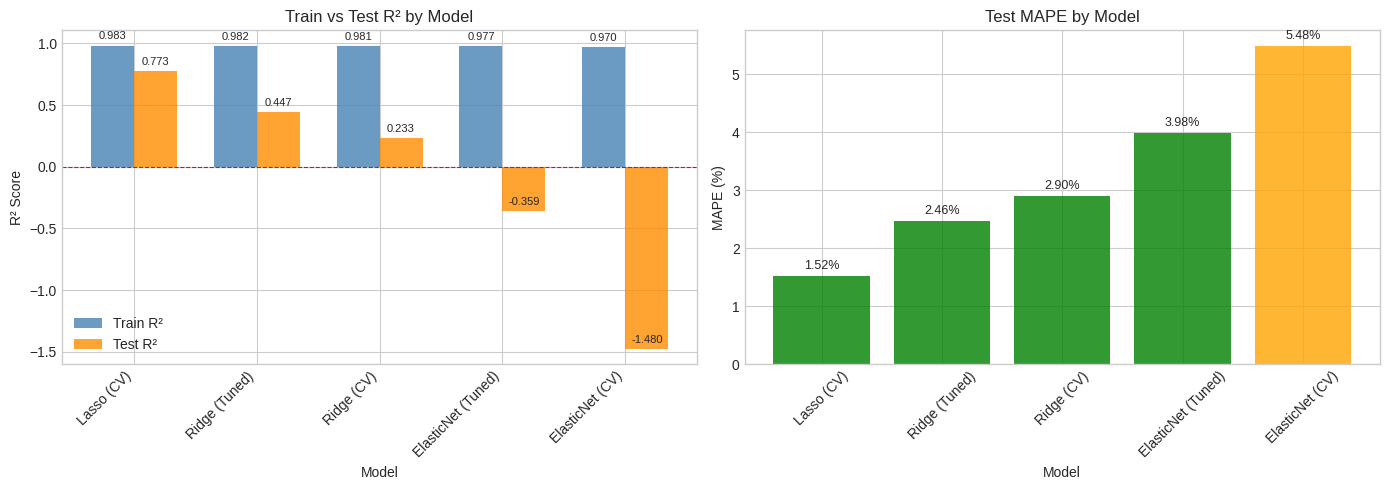

In [29]:
# Visualization of Results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. R² Comparison
ax1 = axes[0]
x = np.arange(len(results_df))
width = 0.35

bars1 = ax1.bar(x - width/2, results_df['Train R²'], width, label='Train R²', color='steelblue', alpha=0.8)
bars2 = ax1.bar(x + width/2, results_df['Test R²'], width, label='Test R²', color='darkorange', alpha=0.8)

ax1.set_xlabel('Model')
ax1.set_ylabel('R² Score')
ax1.set_title('Train vs Test R² by Model')
ax1.set_xticks(x)
ax1.set_xticklabels(results_df['Model'], rotation=45, ha='right')
ax1.legend()
ax1.axhline(y=0, color='red', linestyle='--', linewidth=0.8, label='Zero line')

# Add value labels
for bar in bars1:
    height = bar.get_height()
    ax1.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
                 xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)
for bar in bars2:
    height = bar.get_height()
    ax1.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
                 xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)

# 2. MAPE Comparison
ax2 = axes[1]
colors = ['green' if x < 5 else 'orange' if x < 10 else 'red' for x in results_df['Test MAPE (%)']]
bars = ax2.bar(results_df['Model'], results_df['Test MAPE (%)'], color=colors, alpha=0.8)
ax2.set_xlabel('Model')
ax2.set_ylabel('MAPE (%)')
ax2.set_title('Test MAPE by Model')
ax2.tick_params(axis='x', rotation=45)

for bar in bars:
    height = bar.get_height()
    ax2.annotate(f'{height:.2f}%', xy=(bar.get_x() + bar.get_width()/2, height),
                 xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

---
## STEP 10: Final Model Analysis

In [30]:
print("="*60)
print("FINAL MODEL ANALYSIS")
print("="*60)

# Select best model predictions
if 'Ridge' in best_model_name:
    if 'Tuned' in best_model_name:
        best_model = ridge_grid.best_estimator_
        y_pred_final = y_test_pred_ridge_tuned
    else:
        best_model = ridge_cv
        y_pred_final = y_test_pred_ridge
elif 'Lasso' in best_model_name:
    best_model = lasso_cv
    y_pred_final = y_test_pred_lasso
else:
    if 'Tuned' in best_model_name:
        best_model = enet_grid.best_estimator_
        y_pred_final = y_test_pred_enet_tuned
    else:
        best_model = enet_cv
        y_pred_final = y_test_pred_enet

# Detailed predictions
prediction_df = pd.DataFrame({
    'Month': test_data['month_num_parsed'].values,
    'Actual': y_test.values,
    'Predicted': y_pred_final,
    'Error': y_test.values - y_pred_final,
    'Error %': ((y_test.values - y_pred_final) / y_test.values) * 100
})

print("\n📊 Monthly Predictions for 2025:")
print("-" * 80)
for _, row in prediction_df.iterrows():
    month_name = ['', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov'][int(row['Month'])]
    print(f"   {month_name}: Actual ${row['Actual']/1e6:.2f}M | Predicted ${row['Predicted']/1e6:.2f}M | Error {row['Error %']:.2f}%")

FINAL MODEL ANALYSIS

📊 Monthly Predictions for 2025:
--------------------------------------------------------------------------------
   Jan: Actual $161.80M | Predicted $157.70M | Error 2.54%
   Feb: Actual $163.29M | Predicted $159.80M | Error 2.14%
   Mar: Actual $175.93M | Predicted $173.32M | Error 1.48%
   Apr: Actual $170.68M | Predicted $169.18M | Error 0.88%
   May: Actual $172.46M | Predicted $169.35M | Error 1.80%
   Jun: Actual $171.32M | Predicted $170.85M | Error 0.28%
   Jul: Actual $178.91M | Predicted $173.74M | Error 2.89%
   Aug: Actual $173.45M | Predicted $171.06M | Error 1.37%
   Sep: Actual $177.24M | Predicted $173.83M | Error 1.93%
   Oct: Actual $184.32M | Predicted $183.86M | Error 0.25%
   Nov: Actual $175.46M | Predicted $177.43M | Error -1.13%


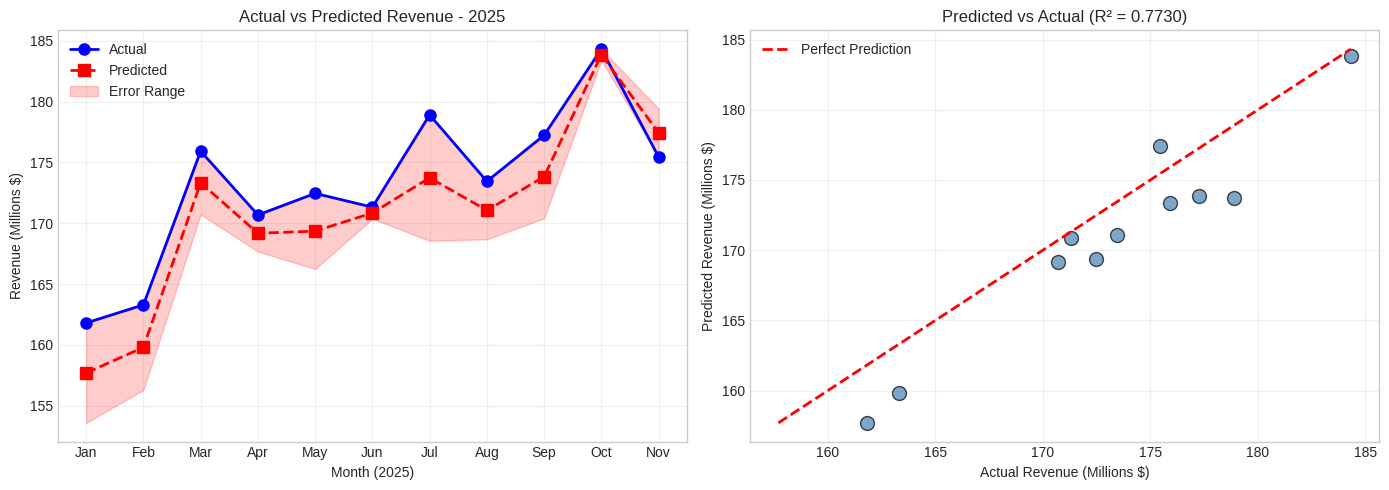

In [31]:
# Prediction vs Actual Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Time series comparison
ax1 = axes[0]
months = prediction_df['Month'].values
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov']

ax1.plot(months, prediction_df['Actual']/1e6, 'b-o', label='Actual', linewidth=2, markersize=8)
ax1.plot(months, prediction_df['Predicted']/1e6, 'r--s', label='Predicted', linewidth=2, markersize=8)
ax1.fill_between(months,
                 (prediction_df['Predicted'] - abs(prediction_df['Error']))/1e6,
                 (prediction_df['Predicted'] + abs(prediction_df['Error']))/1e6,
                 alpha=0.2, color='red', label='Error Range')

ax1.set_xlabel('Month (2025)')
ax1.set_ylabel('Revenue (Millions $)')
ax1.set_title('Actual vs Predicted Revenue - 2025')
ax1.set_xticks(months)
ax1.set_xticklabels([month_labels[int(m)-1] for m in months])
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Scatter plot
ax2 = axes[1]
ax2.scatter(y_test/1e6, y_pred_final/1e6, s=100, alpha=0.7, c='steelblue', edgecolors='black')

# Perfect prediction line
min_val = min(y_test.min(), y_pred_final.min()) / 1e6
max_val = max(y_test.max(), y_pred_final.max()) / 1e6
ax2.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')

ax2.set_xlabel('Actual Revenue (Millions $)')
ax2.set_ylabel('Predicted Revenue (Millions $)')
ax2.set_title(f'Predicted vs Actual (R² = {best_test_r2:.4f})')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('prediction_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

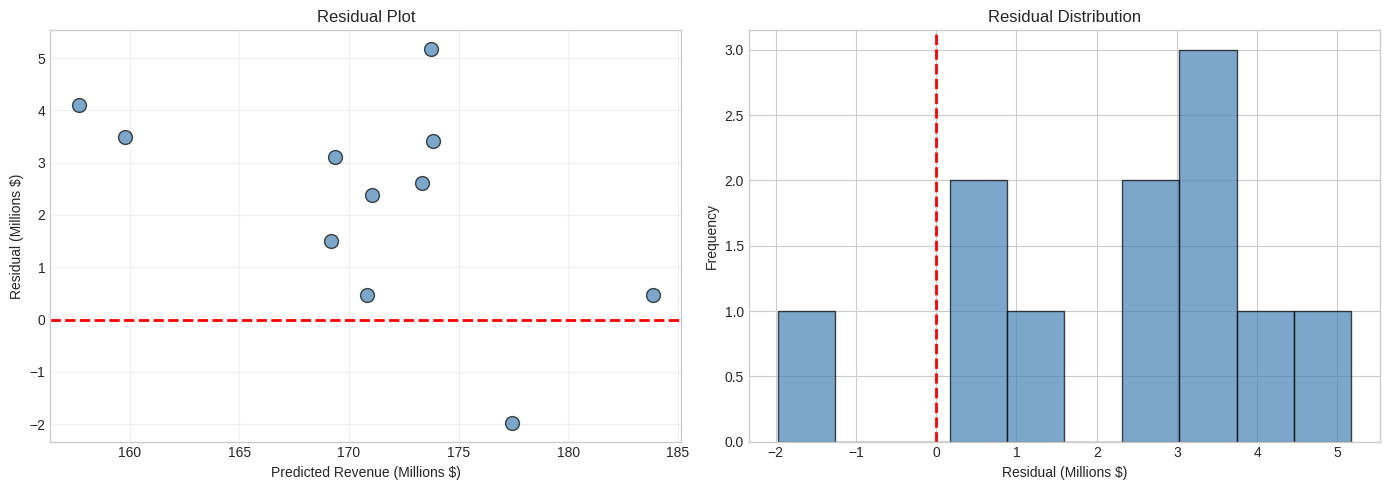


📊 Residual Statistics:
   Mean Residual: $2,249,259
   Std Residual: $1,919,620
   Min Residual: $-1,976,591
   Max Residual: $5,172,416


In [32]:
# Residual Analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

residuals = y_test.values - y_pred_final

# 1. Residual plot
ax1 = axes[0]
ax1.scatter(y_pred_final/1e6, residuals/1e6, s=100, alpha=0.7, c='steelblue', edgecolors='black')
ax1.axhline(y=0, color='red', linestyle='--', linewidth=2)
ax1.set_xlabel('Predicted Revenue (Millions $)')
ax1.set_ylabel('Residual (Millions $)')
ax1.set_title('Residual Plot')
ax1.grid(True, alpha=0.3)

# 2. Residual distribution
ax2 = axes[1]
ax2.hist(residuals/1e6, bins=10, alpha=0.7, color='steelblue', edgecolor='black')
ax2.axvline(x=0, color='red', linestyle='--', linewidth=2)
ax2.set_xlabel('Residual (Millions $)')
ax2.set_ylabel('Frequency')
ax2.set_title('Residual Distribution')

plt.tight_layout()
plt.savefig('residual_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

# Residual statistics
print("\n📊 Residual Statistics:")
print(f"   Mean Residual: ${residuals.mean():,.0f}")
print(f"   Std Residual: ${residuals.std():,.0f}")
print(f"   Min Residual: ${residuals.min():,.0f}")
print(f"   Max Residual: ${residuals.max():,.0f}")

---
## STEP 11: Feature Importance (Coefficients)

FEATURE IMPORTANCE (Model Coefficients)

Feature Coefficients (sorted by importance):
   committed_sign_revenue: +11263003.0714
   committed_unsig_revenue: +2039095.7116
   wtd_pipeline_revenue: +1218842.1197
   committed_unsig_lag1: -834318.9960
   commitment_velocity_3m: +833192.6975
   committed_sign_rolling_std_3: +761690.0981
   committed_sign_lag1: -701162.5771
   pipeline_rolling_mean_3: +693174.3806
   committed_unsig_lag2: +572664.3105
   total_committed_trend: -510994.4722
   ytd_committed_sign: +498071.4526
   committed_sign_lag2: -0.0000


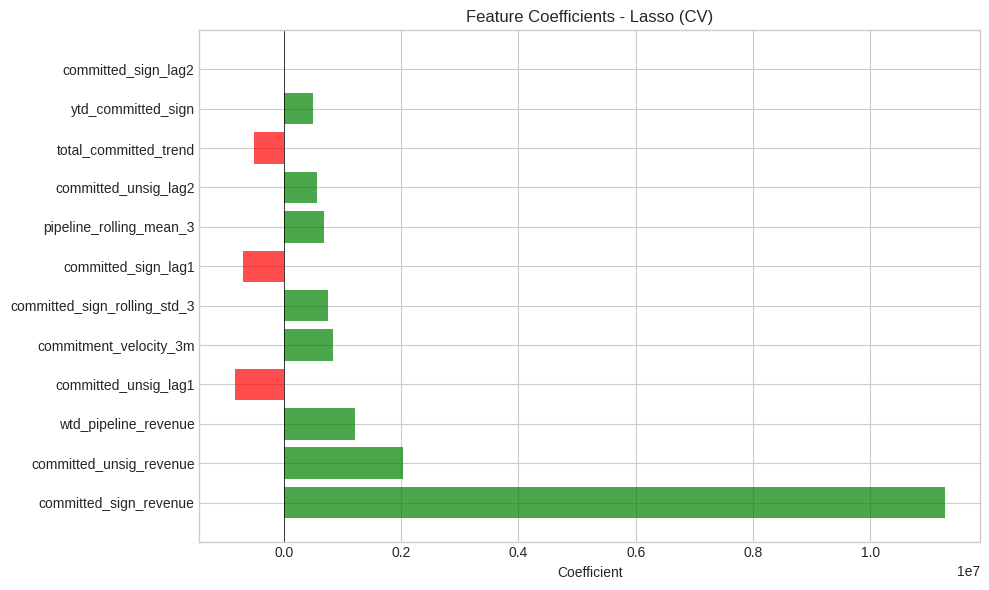

In [33]:
print("="*60)
print("FEATURE IMPORTANCE (Model Coefficients)")
print("="*60)

# Get coefficients from best model
if hasattr(best_model, 'coef_'):
    coefs = best_model.coef_
else:
    coefs = best_model.coef_

coef_df = pd.DataFrame({
    'Feature': final_features,
    'Coefficient': coefs
})
coef_df['Abs_Coefficient'] = abs(coef_df['Coefficient'])
coef_df = coef_df.sort_values('Abs_Coefficient', ascending=False)

print("\nFeature Coefficients (sorted by importance):")
for _, row in coef_df.iterrows():
    sign = '+' if row['Coefficient'] > 0 else '-'
    print(f"   {row['Feature']}: {sign}{abs(row['Coefficient']):.4f}")

# Visualization
plt.figure(figsize=(10, 6))
colors = ['green' if x > 0 else 'red' for x in coef_df['Coefficient']]
plt.barh(range(len(coef_df)), coef_df['Coefficient'], color=colors, alpha=0.7)
plt.yticks(range(len(coef_df)), coef_df['Feature'])
plt.xlabel('Coefficient')
plt.title(f'Feature Coefficients - {best_model_name}')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.savefig('feature_coefficients.png', dpi=150, bbox_inches='tight')
plt.show()

---
## STEP 12: Yearly Forecast with Confidence Interval

In [34]:
print("="*60)
print("YEARLY FORECAST WITH CONFIDENCE INTERVAL")
print("="*60)

# Calculate yearly totals
actual_yearly_2025 = y_test.sum()
predicted_yearly_2025 = y_pred_final.sum()

# Calculate prediction interval based on residual std
residual_std = residuals.std()
n_months = len(y_test)

# 95% confidence interval for yearly total
yearly_std = residual_std * np.sqrt(n_months)
z_score = 1.96  # 95% CI

lower_bound = predicted_yearly_2025 - z_score * yearly_std
upper_bound = predicted_yearly_2025 + z_score * yearly_std

print(f"\n📊 2025 Yearly Forecast (through November):")
print(f"   Actual Total: ${actual_yearly_2025/1e6:.2f}M")
print(f"   Predicted Total: ${predicted_yearly_2025/1e6:.2f}M")
print(f"\n   95% Confidence Interval:")
print(f"   Lower Bound: ${lower_bound/1e6:.2f}M")
print(f"   Upper Bound: ${upper_bound/1e6:.2f}M")
print(f"   Range: ${(upper_bound - lower_bound)/1e6:.2f}M")

# Check if actual falls within CI
if lower_bound <= actual_yearly_2025 <= upper_bound:
    print(f"\n✓ Actual total (${actual_yearly_2025/1e6:.2f}M) is WITHIN the 95% confidence interval!")
else:
    print(f"\n⚠️ Actual total is OUTSIDE the 95% confidence interval.")

YEARLY FORECAST WITH CONFIDENCE INTERVAL

📊 2025 Yearly Forecast (through November):
   Actual Total: $1904.85M
   Predicted Total: $1880.11M

   95% Confidence Interval:
   Lower Bound: $1867.63M
   Upper Bound: $1892.59M
   Range: $24.96M

⚠️ Actual total is OUTSIDE the 95% confidence interval.


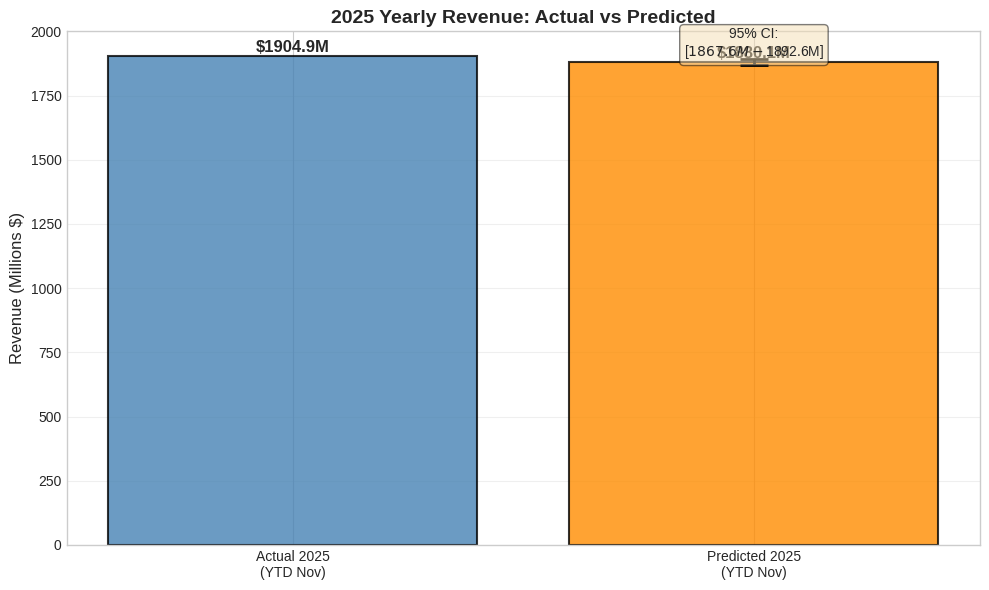

In [35]:
# Yearly comparison visualization
fig, ax = plt.subplots(figsize=(10, 6))

# Bar chart
labels = ['Actual 2025\n(YTD Nov)', 'Predicted 2025\n(YTD Nov)']
values = [actual_yearly_2025/1e6, predicted_yearly_2025/1e6]
colors = ['steelblue', 'darkorange']

bars = ax.bar(labels, values, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

# Error bar for prediction
ax.errorbar(1, predicted_yearly_2025/1e6, yerr=z_score*yearly_std/1e6,
            fmt='none', color='black', capsize=10, capthick=2, linewidth=2)

# Add value labels
for bar, val in zip(bars, values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
            f'${val:.1f}M', ha='center', va='bottom', fontsize=12, fontweight='bold')

# Add CI annotation
ax.annotate(f'95% CI:\n[${lower_bound/1e6:.1f}M - ${upper_bound/1e6:.1f}M]',
            xy=(1, upper_bound/1e6 + 10), ha='center', fontsize=10,
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

ax.set_ylabel('Revenue (Millions $)', fontsize=12)
ax.set_title('2025 Yearly Revenue: Actual vs Predicted', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('yearly_forecast.png', dpi=150, bbox_inches='tight')
plt.show()

---
## STEP 13: Human Forecast Validator

In [36]:
print("="*60)
print("HUMAN FORECAST VALIDATOR")
print("="*60)

def validate_forecast(human_forecast, month_data, model, scaler, features):
    """
    Validate a human forecast against ML prediction.

    Parameters:
    - human_forecast: The analyst's forecasted revenue
    - month_data: DataFrame row with feature values for the month
    - model: Trained model
    - scaler: Fitted scaler
    - features: List of feature names

    Returns:
    - Dictionary with validation results
    """
    # Prepare features
    X = month_data[features].values.reshape(1, -1)
    X_scaled = scaler.transform(X)

    # ML prediction
    ml_prediction = model.predict(X_scaled)[0]

    # Calculate delta
    delta = human_forecast - ml_prediction
    delta_pct = (delta / ml_prediction) * 100

    # Confidence bounds (based on historical residual std)
    confidence_margin = residual_std * 1.96

    # Validation status
    if abs(delta) <= confidence_margin:
        status = "✓ VALIDATED - Within acceptable range"
    else:
        status = "⚠️ REVIEW NEEDED - Outside acceptable range"

    return {
        'human_forecast': human_forecast,
        'ml_prediction': ml_prediction,
        'delta': delta,
        'delta_pct': delta_pct,
        'confidence_margin': confidence_margin,
        'status': status
    }

print("\n📋 Validator Function Created")
print("   Use validate_forecast() to compare analyst forecasts with ML predictions")

HUMAN FORECAST VALIDATOR

📋 Validator Function Created
   Use validate_forecast() to compare analyst forecasts with ML predictions


In [37]:
# Example validation using 2025 data
print("\n--- Example Validation (2025 Months) ---\n")

for idx, row in test_data.iterrows():
    month_num = int(row['month_num_parsed'])
    month_name = ['', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov'][month_num]
    actual = row['actual_revenue']

    # Simulate human forecast (using actual as if it were the forecast)
    human_forecast = actual  # In real use, this would be the analyst's forecast

    result = validate_forecast(human_forecast, row, best_model, scaler, final_features)

    print(f"{month_name} 2025:")
    print(f"   Human Forecast: ${result['human_forecast']/1e6:.2f}M")
    print(f"   ML Prediction:  ${result['ml_prediction']/1e6:.2f}M")
    print(f"   Delta: ${result['delta']/1e6:.2f}M ({result['delta_pct']:.2f}%)")
    print(f"   {result['status']}")
    print()


--- Example Validation (2025 Months) ---

Jan 2025:
   Human Forecast: $161.80M
   ML Prediction:  $157.70M
   Delta: $4.11M (2.61%)
   ⚠️ REVIEW NEEDED - Outside acceptable range

Feb 2025:
   Human Forecast: $163.29M
   ML Prediction:  $159.80M
   Delta: $3.49M (2.19%)
   ✓ VALIDATED - Within acceptable range

Mar 2025:
   Human Forecast: $175.93M
   ML Prediction:  $173.32M
   Delta: $2.60M (1.50%)
   ✓ VALIDATED - Within acceptable range

Apr 2025:
   Human Forecast: $170.68M
   ML Prediction:  $169.18M
   Delta: $1.50M (0.89%)
   ✓ VALIDATED - Within acceptable range

May 2025:
   Human Forecast: $172.46M
   ML Prediction:  $169.35M
   Delta: $3.11M (1.83%)
   ✓ VALIDATED - Within acceptable range

Jun 2025:
   Human Forecast: $171.32M
   ML Prediction:  $170.85M
   Delta: $0.48M (0.28%)
   ✓ VALIDATED - Within acceptable range

Jul 2025:
   Human Forecast: $178.91M
   ML Prediction:  $173.74M
   Delta: $5.17M (2.98%)
   ⚠️ REVIEW NEEDED - Outside acceptable range

Aug 2025:
   H

---
## STEP 14: Final Summary

In [38]:
print("="*60)
print("FINAL SUMMARY")
print("="*60)

print(f"""
🎯 REVENUE FORECASTING MODEL RESULTS
{'='*50}

📊 Best Model: {best_model_name}

📈 Performance Metrics:
   • Test R²: {best_test_r2:.4f}
   • Test MAPE: {best_mape:.2f}%
   • Test MAE: ${mean_absolute_error(y_test, y_pred_final):,.0f}

📋 Features Used: {len(final_features)}
{chr(10).join(['   • ' + f for f in final_features])}

💡 Key Techniques Applied:
   • Target leakage detection
   • RFE (Recursive Feature Elimination)
   • Multicollinearity removal
   • Strong regularization (Ridge, Lasso, ElasticNet)
   • TimeSeriesSplit cross-validation
   • Hyperparameter tuning with GridSearchCV

📉 2025 Yearly Forecast:
   • Predicted: ${predicted_yearly_2025/1e6:.2f}M
   • 95% CI: [${lower_bound/1e6:.2f}M - ${upper_bound/1e6:.2f}M]

✅ Model ready for human forecast validation!
""")

FINAL SUMMARY

🎯 REVENUE FORECASTING MODEL RESULTS

📊 Best Model: Lasso (CV)

📈 Performance Metrics:
   • Test R²: 0.7730
   • Test MAPE: 1.52%
   • Test MAE: $2,608,640

📋 Features Used: 12
   • wtd_pipeline_revenue
   • committed_unsig_revenue
   • committed_sign_revenue
   • committed_sign_lag1
   • committed_sign_lag2
   • committed_unsig_lag1
   • committed_unsig_lag2
   • committed_sign_rolling_std_3
   • pipeline_rolling_mean_3
   • total_committed_trend
   • ytd_committed_sign
   • commitment_velocity_3m

💡 Key Techniques Applied:
   • Target leakage detection
   • RFE (Recursive Feature Elimination)
   • Multicollinearity removal
   • Strong regularization (Ridge, Lasso, ElasticNet)
   • TimeSeriesSplit cross-validation
   • Hyperparameter tuning with GridSearchCV

📉 2025 Yearly Forecast:
   • Predicted: $1880.11M
   • 95% CI: [$1867.63M - $1892.59M]

✅ Model ready for human forecast validation!



In [39]:

# Save model and scaler for future use
import pickle

model_package = {
    'model': best_model,
    'scaler': scaler,
    'features': final_features,
    'residual_std': residual_std,
    'model_name': best_model_name,
    'test_r2': best_test_r2,
    'test_mape': best_mape
}

with open('revenue_forecast_model.pkl', 'wb') as f:
    pickle.dump(model_package, f)

print("✓ Model saved to 'revenue_forecast_model.pkl'")
print("\n📁 Files saved:")
print("   • revenue_forecast_model.pkl (model + scaler + features)")
print("   • model_comparison.png")
print("   • prediction_analysis.png")
print("   • residual_analysis.png")
print("   • feature_coefficients.png")
print("   • yearly_forecast.png")

✓ Model saved to 'revenue_forecast_model.pkl'

📁 Files saved:
   • revenue_forecast_model.pkl (model + scaler + features)
   • model_comparison.png
   • prediction_analysis.png
   • residual_analysis.png
   • feature_coefficients.png
   • yearly_forecast.png
